# DOA Horses
## Classification

We use the dataset “horse.csv”. We want to predict whether a horse can survive based
upon past medical conditions. You can read the metadata in “horse_info.txt”.
The challenge is to predict the “outcome” class.
1. We analyze and prepare the data for classification.
2. We evaluate different algorithms, explore model & training parameters.
3. We investigate the learning process critically (overfitting/underfitting)
4. We improve and present the obtained results.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import f_oneway, chi2_contingency

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve, precision_score, roc_auc_score, precision_recall_fscore_support

# Load data

In [2]:
df = pd.read_csv("horse.csv")

# EDA

In [3]:
df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


lived         178
died           77
euthanized     44
Name: outcome, dtype: int64


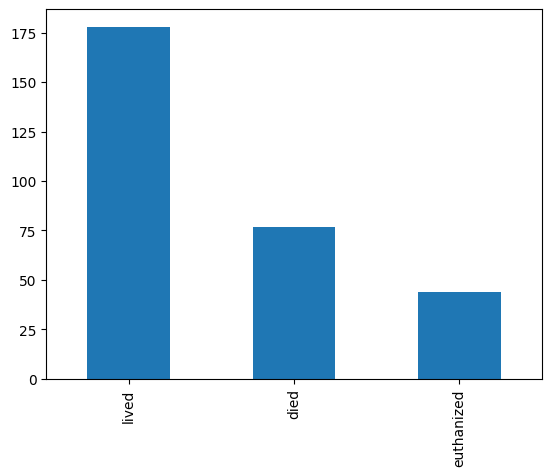

In [4]:
# The outcome classes are not entirely balanced. Something to keep in mind when we construct models later on.
df['outcome'].value_counts().plot(kind='bar')
print(df['outcome'].value_counts())

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            239 non-null    float64
 4   pulse                  275 non-null    float64
 5   respiratory_rate       241 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  nasogastric_reflux     193 non-null    object 
 15  nasoga

If more than half the instances of a features is missing, there is really no point in using that feature. I also build in some functionality to select for the missing features seperately in the next step.

In [6]:
# Make a list that contains the features and a list that contains the non-null values for each feature.
# The 'complete' column is created to easily select features that have missing values (in the next cell).
features = list(df.count().index)
non_null_count = list(df.count())
complete = list(df.count()==len(df))

# Create dataframe based on these lists
feature_null_count = pd.DataFrame(zip(non_null_count, complete), columns=['non_null_count','complete'], index=features)

# Retain only the features with a non-null count above a certain threshold value, which we set to 0.5
# It seems reasonable to me that a feature whose values are missing more than half the time will not be a good feature.
threshold = 0.5
feature_null_count_capped = feature_null_count[feature_null_count['non_null_count']>threshold*len(df)]

# Create the list of features that we want to retain in the dataset
feature_list = list(feature_null_count_capped.index)

In [7]:
# These are the features that have missing values:
features_w_missings = list(feature_null_count_capped[feature_null_count_capped['complete']==False].index)

In [8]:
features_w_missings

['rectal_temp',
 'pulse',
 'respiratory_rate',
 'temp_of_extremities',
 'peripheral_pulse',
 'mucous_membrane',
 'capillary_refill_time',
 'pain',
 'peristalsis',
 'abdominal_distention',
 'nasogastric_tube',
 'nasogastric_reflux',
 'rectal_exam_feces',
 'abdomen',
 'packed_cell_volume',
 'total_protein']

Now we check the distribution of the missing features among the target categories, to get an idea about how we can impute.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


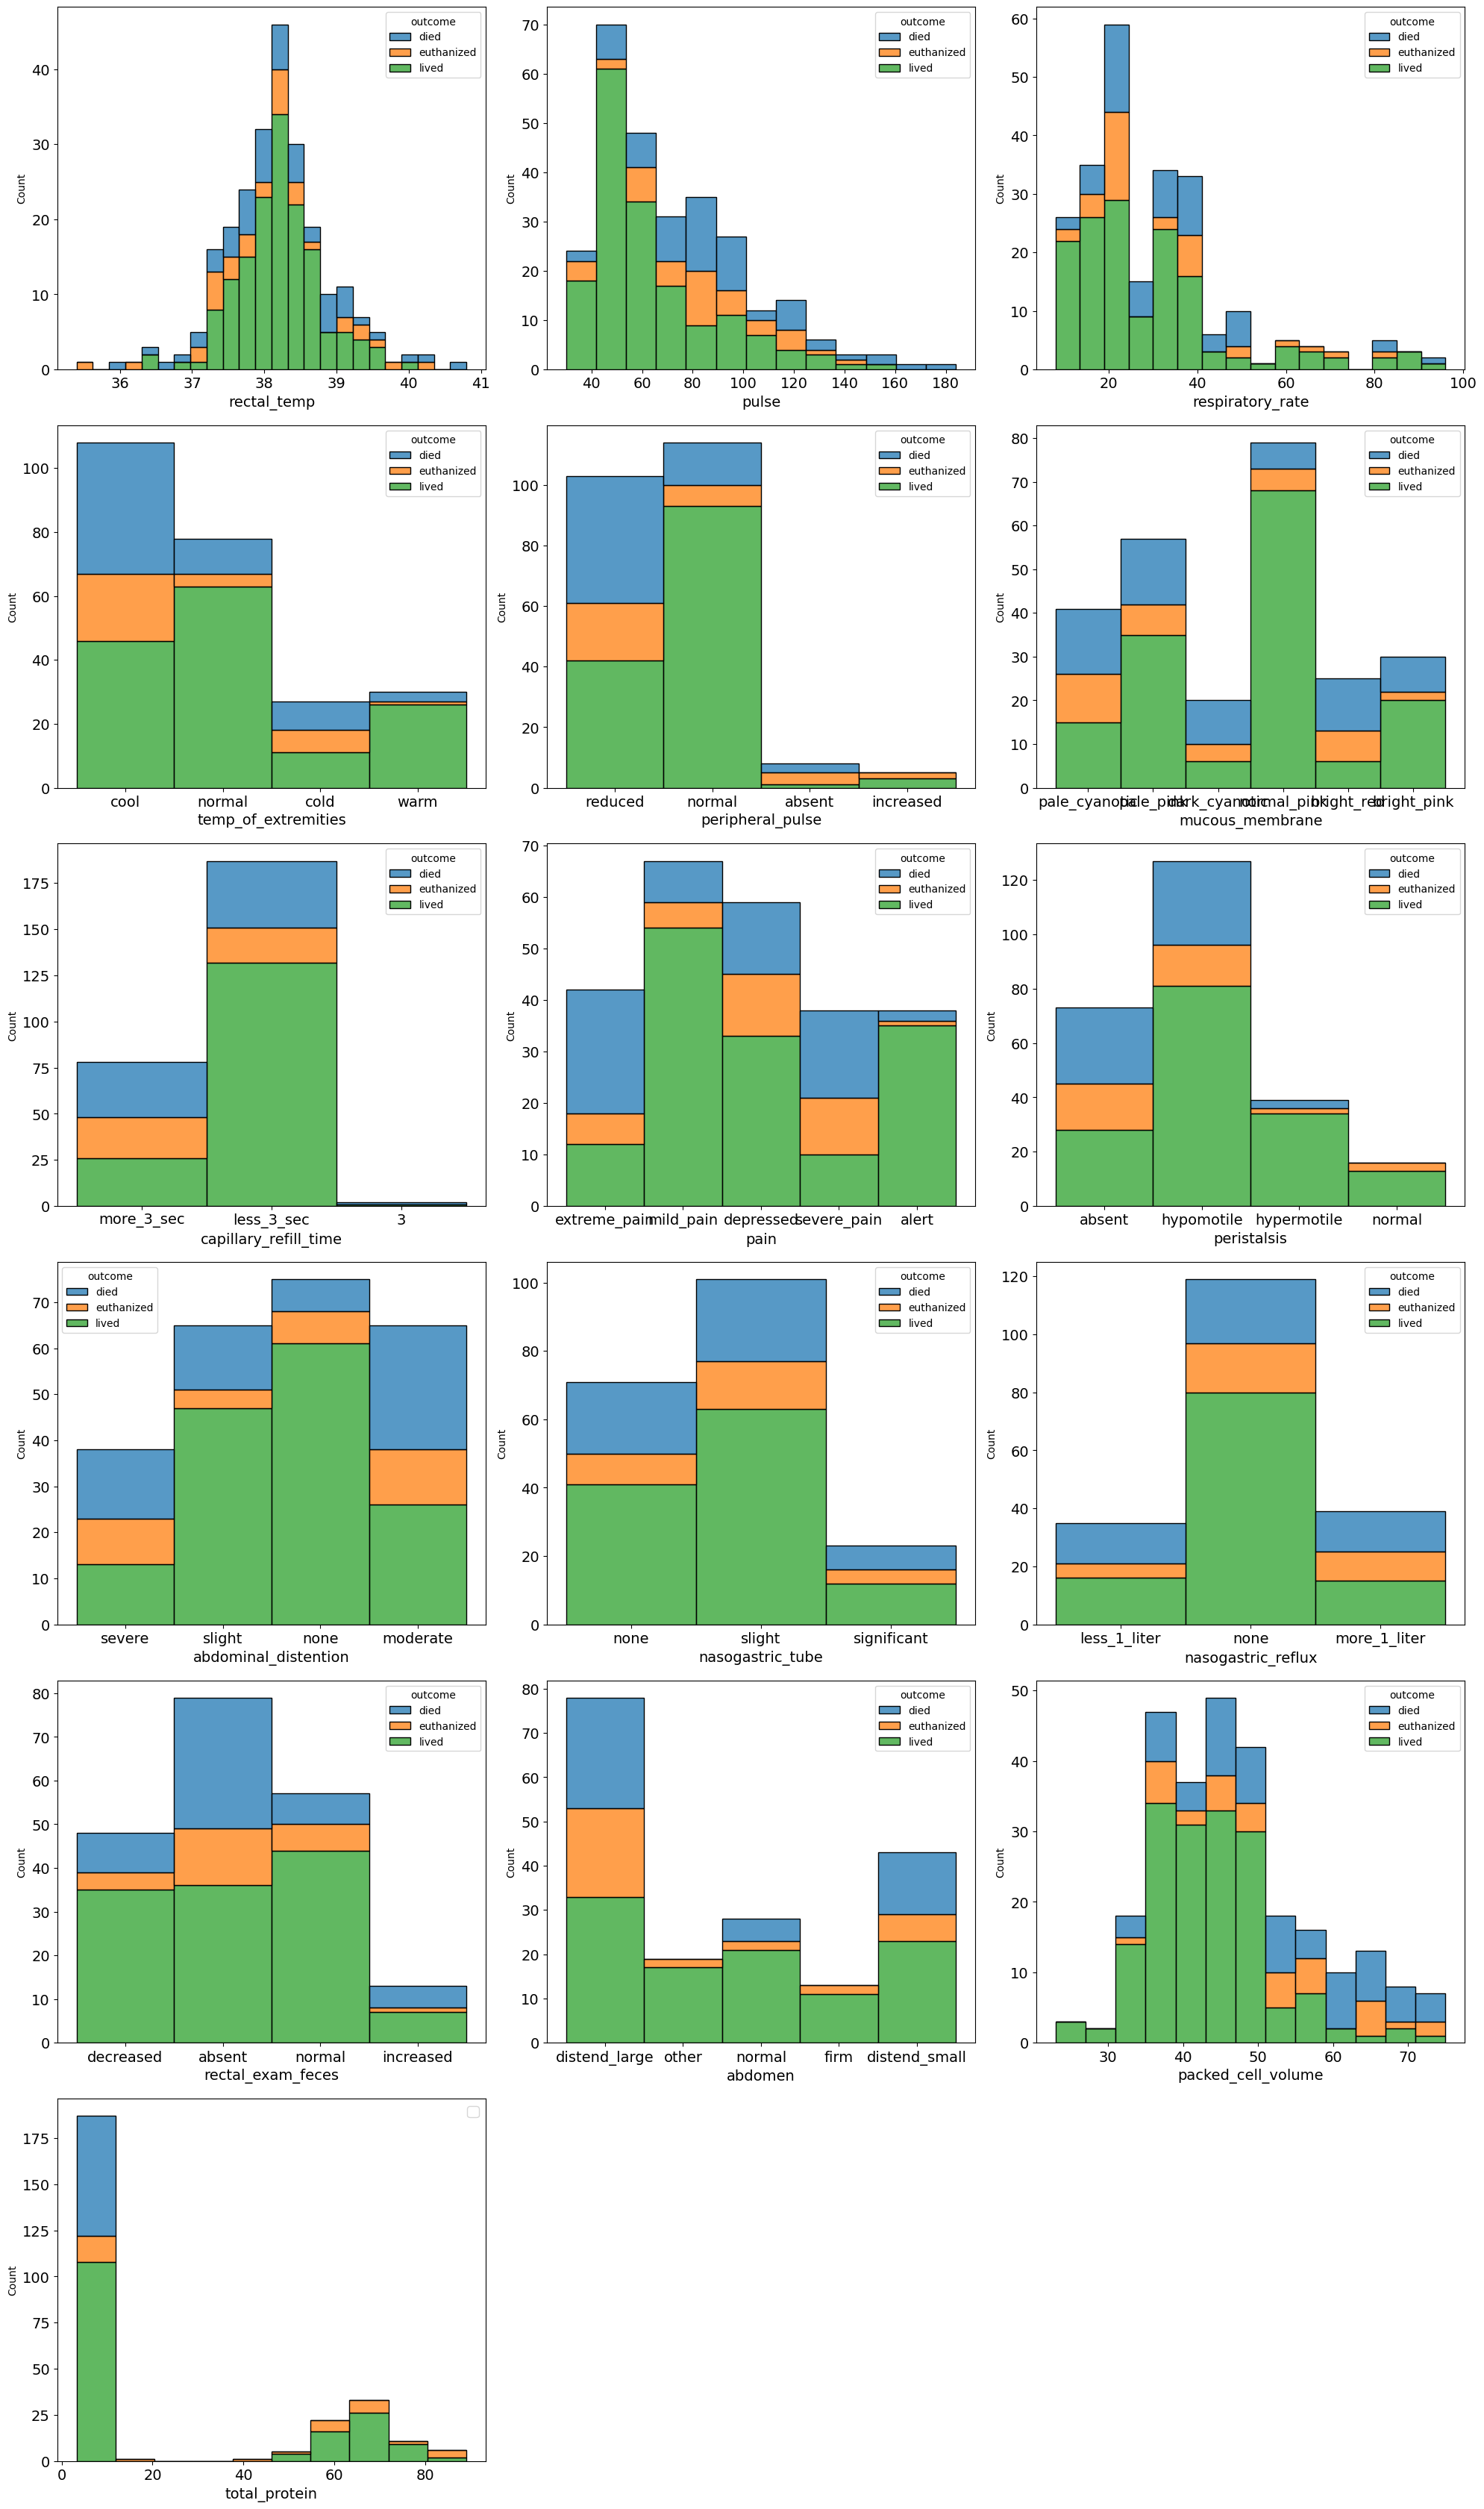

In [9]:
plt.rcParams["figure.figsize"] = (20,50)
for i, feature in enumerate(features_w_missings):
        ax = plt.subplot(9,3,i+1)
        sns.histplot(x=feature, hue='outcome', multiple='stack', data=df[[feature,'outcome']])
        plt.xlabel(feature,fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)    
plt.tight_layout()
plt.legend(fontsize=14, loc='upper right')
plt.show()

A quick check for the distribution of the remaining features:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


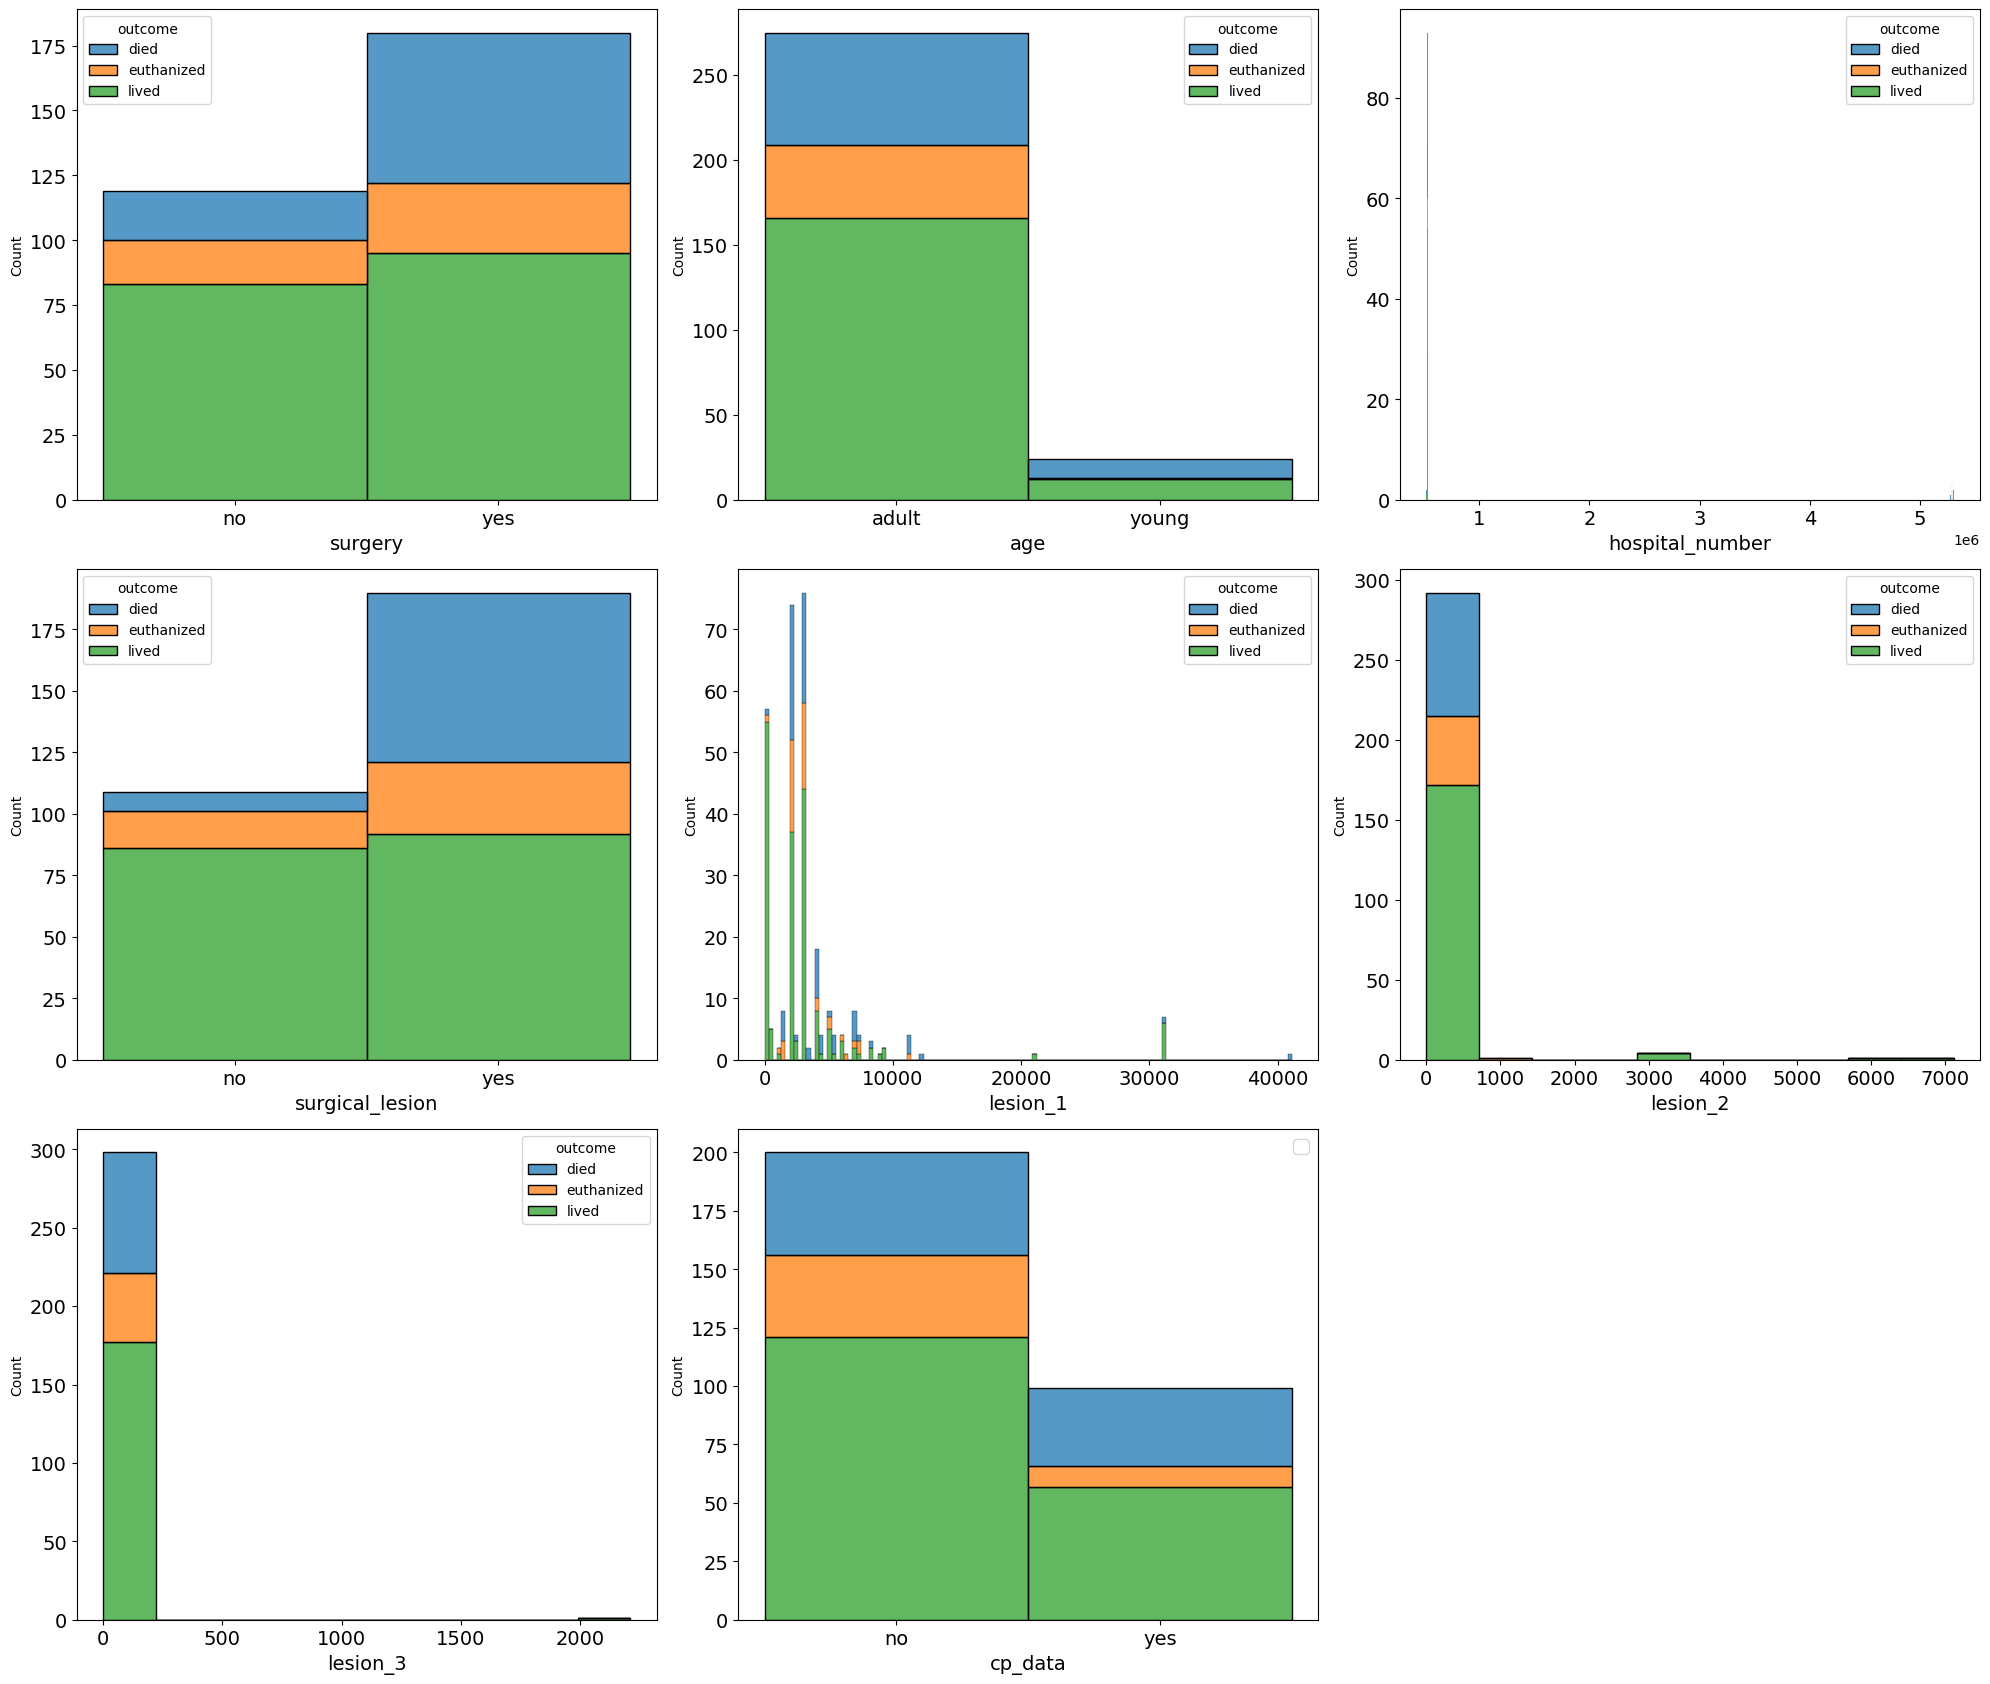

In [10]:
templist=[feature for feature in feature_list if feature not in features_w_missings]
templist.remove('outcome')
plt.rcParams["figure.figsize"] = (20,50)
for i, feature in enumerate(templist):
        ax = plt.subplot(9,3,i+1)
        sns.histplot(x=feature, hue='outcome', multiple='stack', data=df[[feature,'outcome']])
        plt.xlabel(feature,fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)    
plt.tight_layout()
plt.legend(fontsize=14, loc='upper right')
plt.show()

'Hospital_number' can be removed, since there are almost as many hospital numbers as records. (If there were only a few, you could argue there could be a difference in quality between hospitals and then it would be relevant.)
We should not expect too much from lesion_3 either, as it contains nearly all the same entries.

In [11]:
feature_list.remove('hospital_number')

In [12]:
feature_list

['surgery',
 'age',
 'rectal_temp',
 'pulse',
 'respiratory_rate',
 'temp_of_extremities',
 'peripheral_pulse',
 'mucous_membrane',
 'capillary_refill_time',
 'pain',
 'peristalsis',
 'abdominal_distention',
 'nasogastric_tube',
 'nasogastric_reflux',
 'rectal_exam_feces',
 'abdomen',
 'packed_cell_volume',
 'total_protein',
 'outcome',
 'surgical_lesion',
 'lesion_1',
 'lesion_2',
 'lesion_3',
 'cp_data']

Now the missing values are imputed. I chose to simply use the mean and mode for numerical and categorical variables, respectively, due to a time crunch on my part. The histograms shown above do seem to justify this practice. If I had more time I would try to fill in blanks by using an actual model that uses the features without missings to make a calculated prediction of the missing values.<br>
Note that I proceed using the entire dataset in one go for the imputation. Generally speaking, this is bad practice because this way information information of the train set can leak into the test set. However, I noticed that doing the imputation on train and test set separately, all my models were overfitting much more (not shown in this notebook), and therefore I reverted back to imputation on the full dataset. I assume this might be debatable. The reason for the increased overfitting with yet properly imputed train and test is likely a result of the dataset being very small with 299 records, so imputation with even less information can lead to the model learning patterns that are specific to the train set but not well generalizable to the test set.

In [13]:
# Replace missings with mean and mode for numerical and categorical variables, respectively.

for i, feature in enumerate(features_w_missings):
    if df[feature].dtype=='object':
        df[feature].fillna(df[feature].mode()[0], inplace=True)
    else:
        df[feature].fillna(df[feature].mean(), inplace=True)    

In [14]:
df[feature_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   rectal_temp            299 non-null    float64
 3   pulse                  299 non-null    float64
 4   respiratory_rate       299 non-null    float64
 5   temp_of_extremities    299 non-null    object 
 6   peripheral_pulse       299 non-null    object 
 7   mucous_membrane        299 non-null    object 
 8   capillary_refill_time  299 non-null    object 
 9   pain                   299 non-null    object 
 10  peristalsis            299 non-null    object 
 11  abdominal_distention   299 non-null    object 
 12  nasogastric_tube       299 non-null    object 
 13  nasogastric_reflux     299 non-null    object 
 14  rectal_exam_feces      299 non-null    object 
 15  abdome

In [41]:
# We reduce the dataframe to only contain the columns from feature_list
df = df[feature_list]

# Feature reduction

Here I made an attempt to reduce the number of features. By conducting a correlation analysis between the individual features and the target, I removed the features with p-values below 0.25. Without becoming overly verbose on statistics theory, I'll say this is very tolerant. Purposefully so, because I only wanted to remove the ones with basically no correlation to the target, and I wanted to be safe not to remove features that could still be useful as a combination.

In [21]:
df_cat = df.select_dtypes(include=['object'])
df_num = df.select_dtypes(exclude=['object'])

In [22]:
# Anova test for numerical variables. All values are printed, but only p<0.25 is kept.
num_keep=[]
for feature in df_num.columns:
    statistic, pvalue = f_oneway(df[feature][df['outcome']=='lived'], df[feature][df['outcome']=='died'], df[feature][df['outcome']=='euthanized'])
    print(feature,' :', round(pvalue,6))
    if pvalue<0.25:
        num_keep.append(feature)

rectal_temp  : 0.615505
pulse  : 0.0
respiratory_rate  : 0.391966
packed_cell_volume  : 0.0
total_protein  : 0.0
lesion_1  : 0.171547
lesion_2  : 0.217028
lesion_3  : 0.713201


In [23]:
# Chi square test for categorical variables. All values are printed, but only p<0.25 is kept.
cat_keep=[]
for feature in df_cat.columns:
    stat, pvalue, dof, expected = chi2_contingency(pd.crosstab(df[feature], df['outcome']))
    print(feature,' :', round(pvalue,6))
    if pvalue<0.25:
        cat_keep.append(feature)

surgery  : 0.004424
age  : 0.039607
temp_of_extremities  : 1e-06
peripheral_pulse  : 0.0
mucous_membrane  : 1e-06
capillary_refill_time  : 1e-06
pain  : 0.0
peristalsis  : 1.6e-05
abdominal_distention  : 6e-06
nasogastric_tube  : 0.821993
nasogastric_reflux  : 0.005416
rectal_exam_feces  : 0.005292
abdomen  : 0.014331
outcome  : 0.0
surgical_lesion  : 0.0
cp_data  : 0.037253


In [24]:
feature_list = num_keep+cat_keep
feature_list

['pulse',
 'packed_cell_volume',
 'total_protein',
 'lesion_1',
 'lesion_2',
 'surgery',
 'age',
 'temp_of_extremities',
 'peripheral_pulse',
 'mucous_membrane',
 'capillary_refill_time',
 'pain',
 'peristalsis',
 'abdominal_distention',
 'nasogastric_reflux',
 'rectal_exam_feces',
 'abdomen',
 'outcome',
 'surgical_lesion',
 'cp_data']

# Create train and test sets

Note that I do not perform any scaling yet. For tree-based methods this is not required. Honestly, I did try it because it would come in handy for the other models, but my decision tree model became worse, which does not make sense. I do not have a good explanation for this.

In [25]:
# Split dataset into independent variables (X) and target variable (y).
Xy = df[feature_list]
X = Xy.drop(['outcome'], axis=1)
y = Xy['outcome']

X = pd.get_dummies(X)

# Randomly generate train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

# Create functions for insightful evaluation

In [17]:
def plot_classification_report(y_true, y_pred, test_or_train, ax):
    
    '''
    Plot the precision, recall, and f1-score for each class
    '''
    precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

    #fig, ax = plt.subplots(figsize=(4,4))
    barWidth = 0.25

    r = np.arange(len(precision))

    rects1 = ax.bar(r, precision, barWidth, label='Precision', color='r')
    rects2 = ax.bar(r + barWidth, recall, barWidth, label='Recall', color='g')
    rects3 = ax.bar(r + 2*barWidth, f1_score, barWidth, label='F1-score', color='b')

    ax.set_title('Classification report\n{} accuracy: {:.3f}'.format(test_or_train, accuracy_score(y_true, y_pred)))
    ax.set_xticks(r + barWidth)
    ax.set_xticklabels(sorted(list(pd.Series(y_true).unique())))
    ax.legend(loc='best')
    ax.set_ylim(0, 1.4)
    ax.set_yticks(np.arange(0,1.1,0.1))
        
    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)
    for rect in rects2:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)
    for rect in rects3:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

    #plt.show() is omitted here because otherwise only the first call of this function is displayed.

In [18]:
def evaluate_model(y_train, y_train_pred, y_test, y_test_pred):

    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    plot_classification_report(y_train, y_train_pred, 'train',ax=axs[0])
    plot_classification_report(y_test, y_test_pred, 'test',ax=axs[1])
    
    plt.rcParams["figure.figsize"] = (15,5)
    fig, axs = plt.subplots(1,2)

    sns.heatmap(confusion_matrix(y_train, y_train_pred, labels= sorted(list(pd.Series(y_train).unique()))), annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, ax=axs[0])
    sns.heatmap(confusion_matrix(y_test, y_test_pred, labels= sorted(list(pd.Series(y_test).unique()))), annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, ax=axs[1])

    axs[0].set(xticklabels=sorted(list(set(y_train_pred))), yticklabels=sorted(list(pd.Series(y_train_pred).unique())))
    axs[1].set(xticklabels=sorted(list(set(y_test_pred))), yticklabels=sorted(list(pd.Series(y_test_pred).unique())))
    for ax in axs.flat:
        ax.set_xlabel("Predicted", fontsize=14)
        ax.set_ylabel("True", fontsize=14)
    
    for ax in axs.flat:
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

    axs[0].set_title("TRAIN")
    axs[1].set_title("TEST")
    
    fig.tight_layout()
    plt.show()
#https://blog.finxter.com/how-to-plot-sklearn-confusion-matrix-with-labels/ => labels in alphabetical order!

# Modelling

## Decision tree

A decision tree classifier is initiated and a grid of hyperparameters is defined.
- I chose the class_weight='balanced' option as fixed, because the dataset is in fact fairly unbalanced and we want to take that into the equation (This makes a big difference, I tested).
- The simpler the tree, the better, so I started max_depth at 2, and went up to 15, which is pretty deep given the number of features in the dataset.
- I ultimately chose 2 to 15 as boundaries for the minimum samples to split or be in the leaves, being cautious for overfitting if the boundary is too low.

Then a grid search is performed with 5-fold cross-validation. I chose f1_weighted as metric because the f1 score balances precision and recall and the weighted variety takes class imbalance into account.

In [26]:
# Generate an decision tree instance
DT_clf = DecisionTreeClassifier(class_weight='balanced', random_state=0)

# Define a grid of hyperparameters
params = [{
    'criterion': ['gini','entropy'],
    'max_depth': [2,4,6,8,10,15],
    'min_samples_split': [2,3,5,7,10,15],
    'min_samples_leaf': [2,3,5,7,10,15]
          }]

# Generate a GridSearchCV instance
DT_clf_GS = GridSearchCV(DT_clf,
                      param_grid=params,
                      scoring='f1_weighted',
                      cv=5)
DT_clf_GS.fit(X_train, y_train)

# Select the best combination of hyperparameters
best_estimator = DT_clf_GS.best_estimator_
print('The best performing combination of hyperparameters is:\n ', DT_clf_GS.best_params_)

The best performing combination of hyperparameters is:
  {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5}


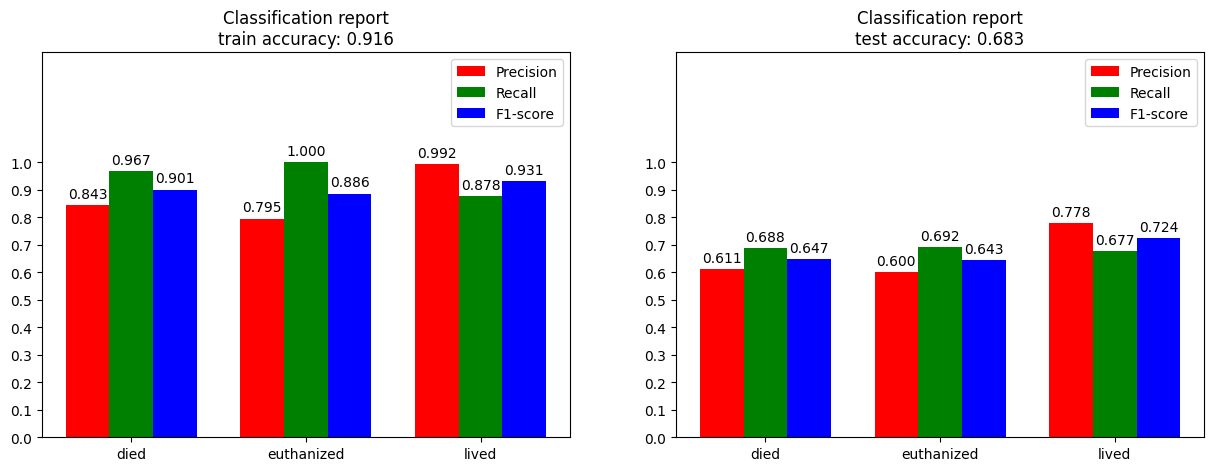

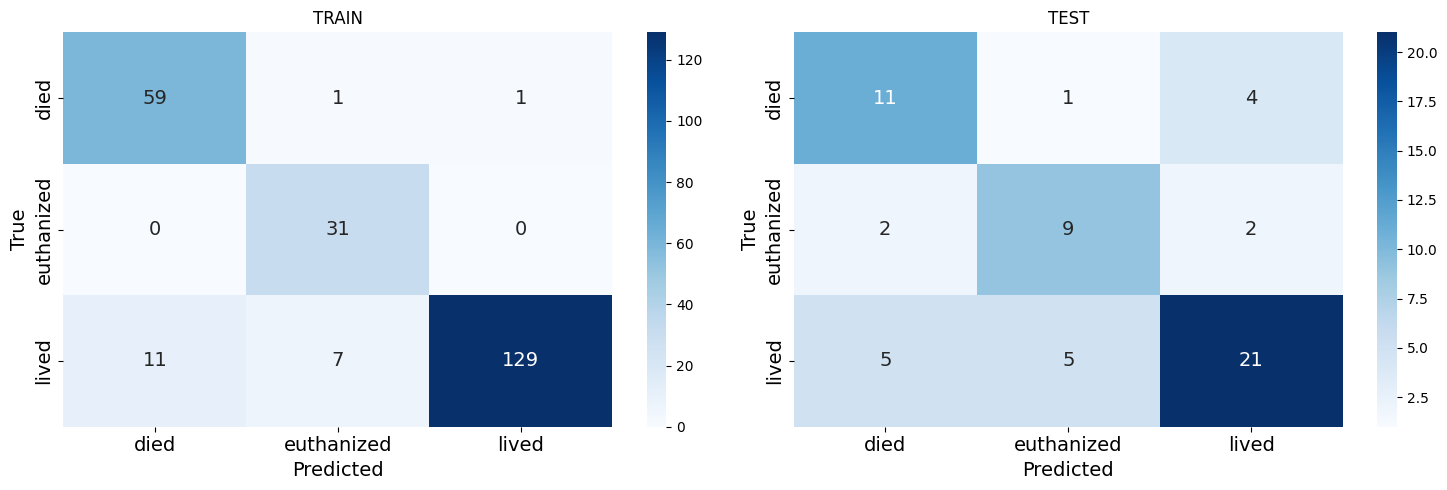

In [27]:
evaluate_model(y_train, best_estimator.predict(X_train), y_test, best_estimator.predict(X_test))

The resulting model appears to be overfit to the training data: all the metrics are around 0.9 for the training set, but drop to 0.7-ish for the test set. Nevertheless, the predictive power is homogeneous over the classes.
It was a risk choosing the lower boundaries of min_samples_split and min_samples_leaf as low as 2, but the overfitting remained if I put the lower boundaries higher. Combatting overfitting could entail getting additional data or omitting some features. I tried omitting features with lower correlation to the target (see the 'Optional' section above), but that considerably degraded performance overall (not shown in this notebook).<br>How good this model really is depends on what the sponsor of the analysis finds important... What does the sponsor use the model for? For example, I could imagine it takes a long time to order a new breed of horses and the sponsor wants an early prediction of whether a current horse will survive or not. If the sponsor needs to have a minimum amount of horses at all times it is more important to predict when a horse would likely die because then a newly bred horse can already be ordered, just to be safe.


## Random Forest

In this case I do not immediately start with grid search, just to illustrate that a near perfect prediction is possible on the train set, but that seems to be a convincing case of overfitting, as demonstrated by the much lower performance of the test set.

In [37]:
RF_clf = RandomForestClassifier(bootstrap=True, criterion='entropy', max_depth=15, max_features='auto', min_samples_leaf=1, min_samples_split=4, n_estimators = 150, random_state = 0)
# Instantiate model with 100 decision trees
#RF_clf = RandomForestClassifier(n_estimators = 1000, random_state = 0)
# Train the model on training data
RF_clf.fit(X_train, y_train);

y_train_pred = RF_clf.predict(X_train)
y_test_pred = RF_clf.predict(X_test)

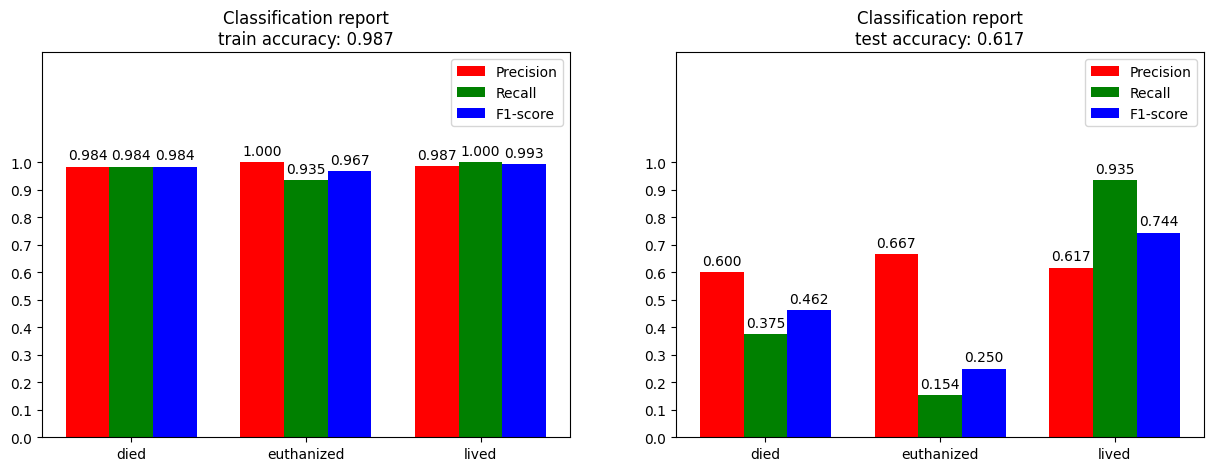

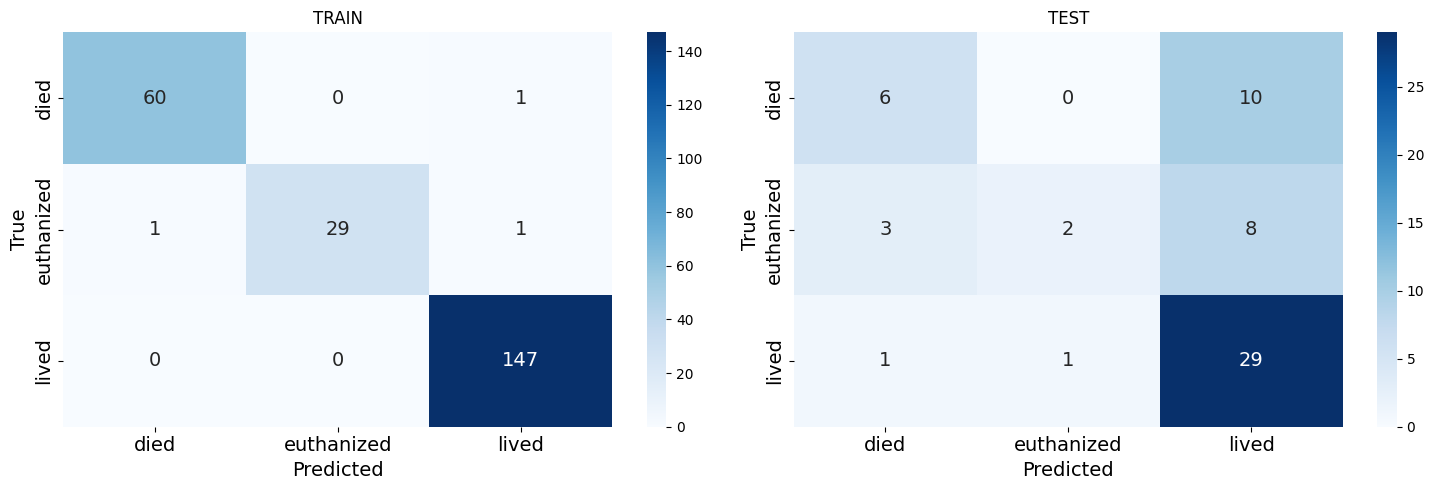

In [38]:
evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

In [39]:
# Generate an instance
RF_clf = RandomForestClassifier(class_weight='balanced', random_state = 0)

# Define a grid of hyperparameters
params = [{
    'criterion': ['gini','entropy'],
    'n_estimators': [10,100,1000],
    'max_depth': [2,4,6],
    'min_samples_split': [5,7,10,15],
    'min_samples_leaf': [5,7,10,15]
          }]

# Generate a GridSearchCV instance
RF_clf_GS = GridSearchCV(RF_clf,
                      param_grid=params,
                      scoring='f1_weighted',
                      cv=5)
RF_clf_GS.fit(X_train, y_train)

# Select the best combination of hyperparameters
best_estimator = RF_clf_GS.best_estimator_
print('The best performing combination of hyperparameters is:\n ', RF_clf_GS.best_params_)

The best performing combination of hyperparameters is:
  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}


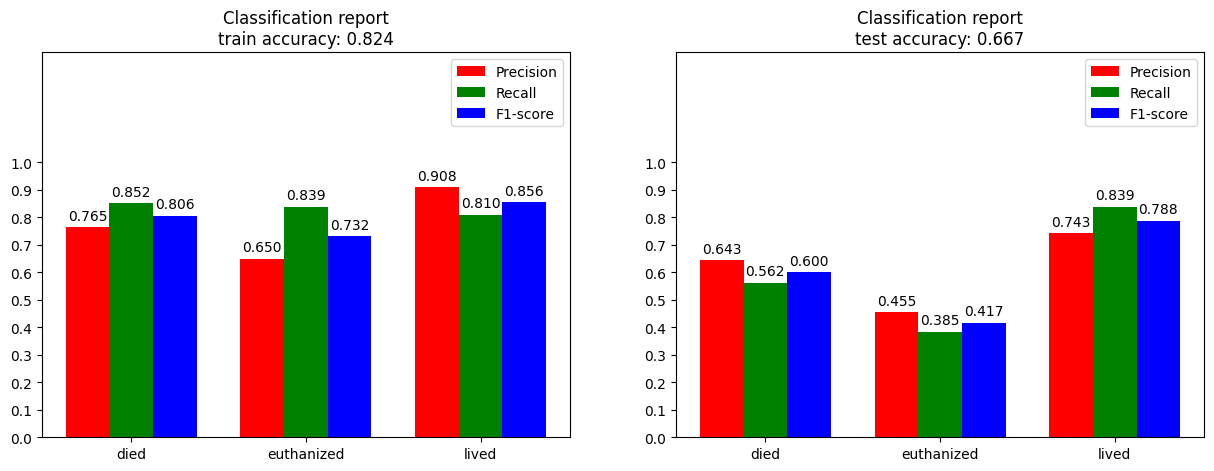

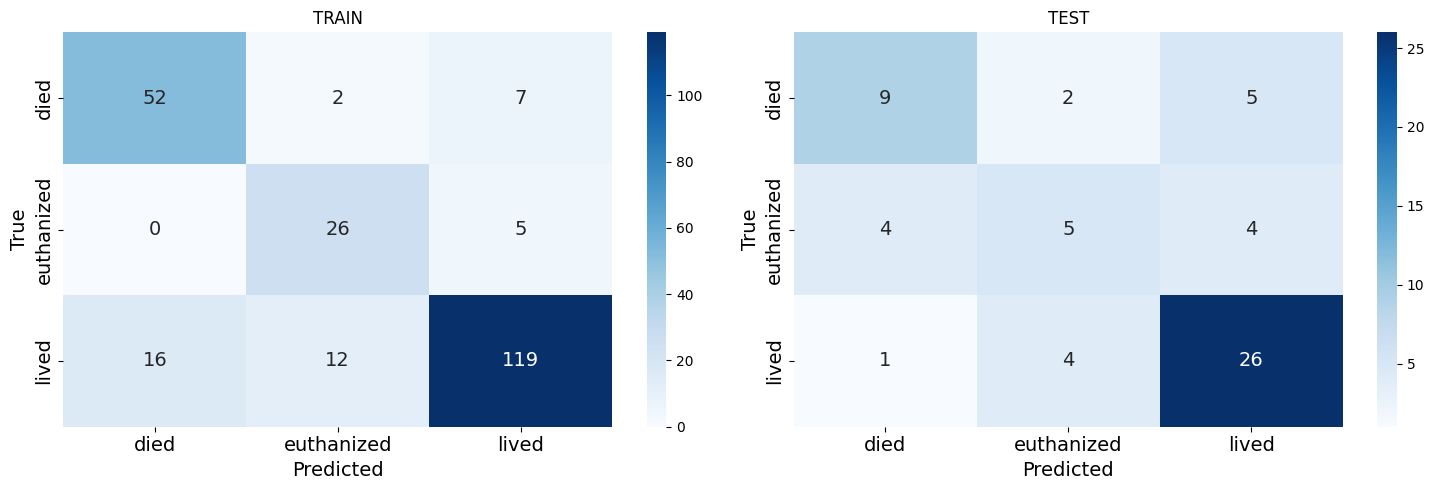

In [40]:
evaluate_model(y_train, best_estimator.predict(X_train), y_test, best_estimator.predict(X_test))

This result surprises me because an ensemble method such as random forest does bring in regularization, but the 'died' and 'euthanized' class are still noticeably overfit, and the performance is also lower for these classes. 

# KNN

In [28]:
knn_clf = KNeighborsClassifier()

# Define a grid of hyperparameters
params = [{
    'metric': ['euclidian', 'manhattan','minkowski','jaccard', 'mahalanobis'],
    'weights': ['uniform','distance'],
    'n_neighbors': [5,7,9,11,13,15],
    'p': [1,2]
          }]

# Generate a GridSearchCV instance
knn_clf_GS = GridSearchCV(knn_clf,
                      param_grid=params,
                      scoring='f1_weighted',
                      cv=5)
knn_clf_GS.fit(X_train, y_train)

# Select the best combination of hyperparameters
best_estimator = knn_clf_GS.best_estimator_
print('The best performing combination of hyperparameters is:\n ', knn_clf_GS.best_params_)

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertcon

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metr

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over whi

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertcon

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over whi

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/skl

The best performing combination of hyperparameters is:
  {'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/bertconings/opt/anaconda3/lib/python3.9/site-packages/skl

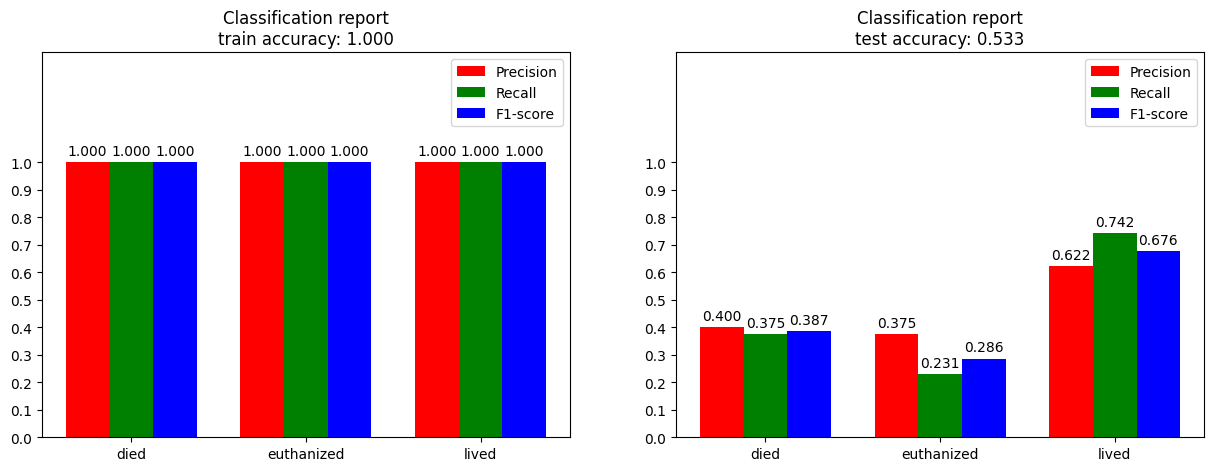

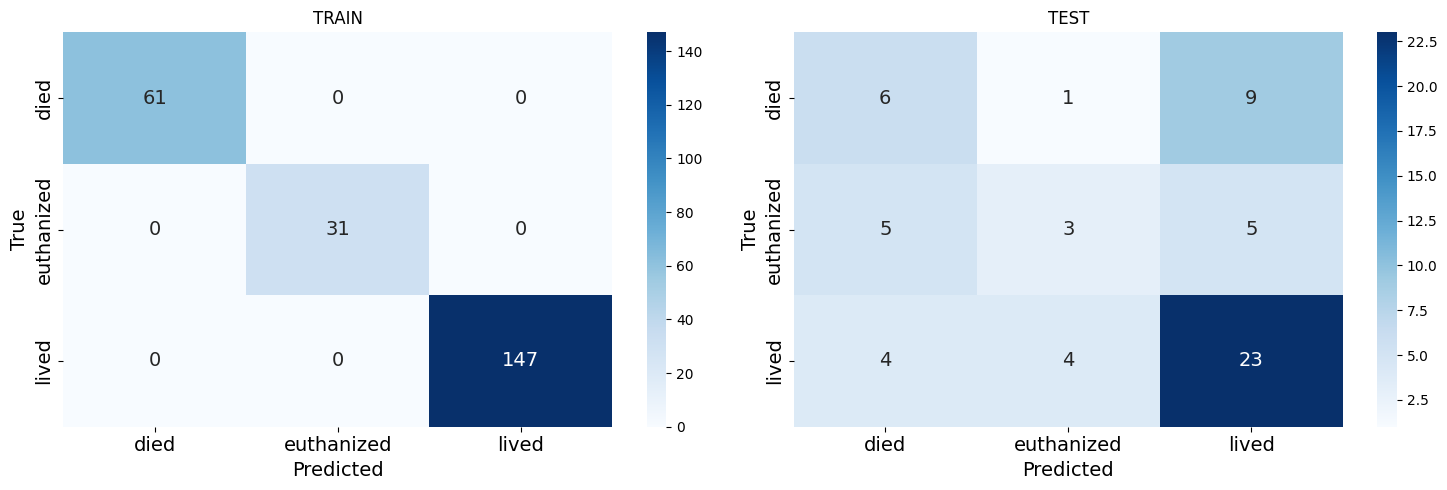

In [29]:
evaluate_model(y_train, best_estimator.predict(X_train), y_test, best_estimator.predict(X_test))

Again, a great deal of overfitting here. We are already using distance weighing, including Mahalanobis distance to be more robust to outliers. Increasing n does not help either. I'm at a loss (no pun intended).

# Support vector machine

In [30]:
# Here we do need to scale
mm_scaler = MinMaxScaler()
Xy = pd.concat([pd.DataFrame(mm_scaler.fit_transform(df_num), columns=df_num.columns), df_cat], axis=1)

# Split dataset into independent variables (X) and target variable (y).
#Xy = df[feature_list]
X = Xy.drop(['outcome'], axis=1)
y = Xy['outcome']

X = pd.get_dummies(X)

# Randomly generate train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

In [31]:
from sklearn.svm import SVC
svm_clf=SVC(gamma='auto', kernel='linear')
svm_clf.fit(X_train, y_train);

y_train_pred = svm_clf.predict(X_train)
y_test_pred = svm_clf.predict(X_test)

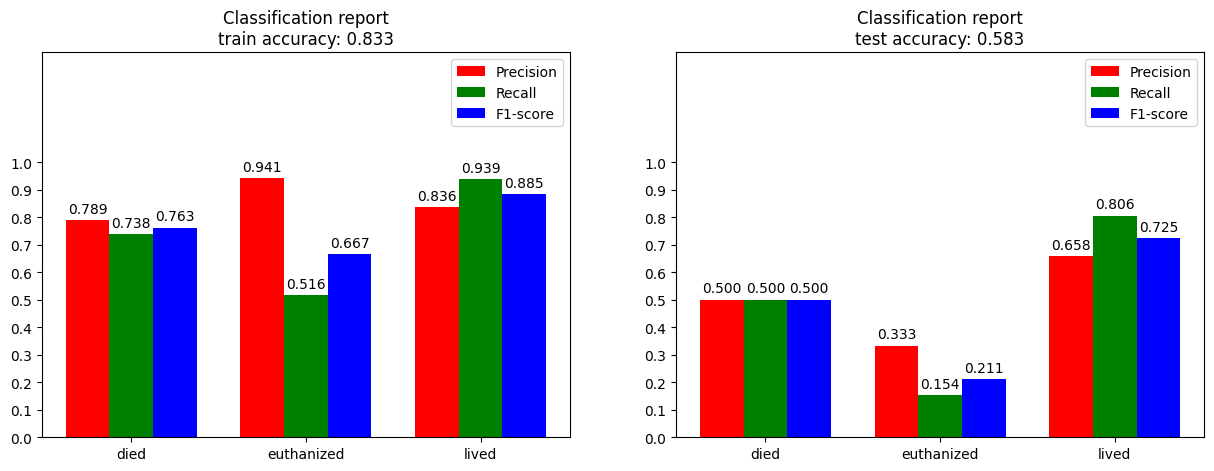

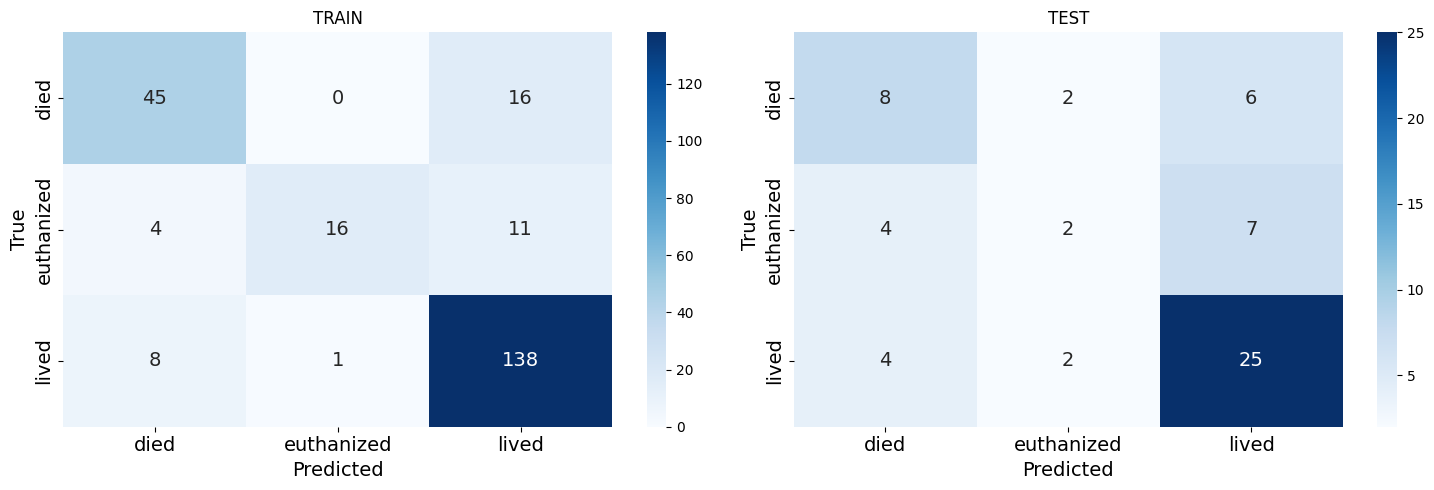

In [32]:
evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

In [42]:
# Define a grid of hyperparameters
params = [{
    'gamma': ['scale','auto'],
    'C': [0.01,0.1, 0.2],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [1,2,3]
          }]

# Generate a GridSearchCV instance
svm_clf_GS = GridSearchCV(svm_clf,
                      param_grid=params,
                      scoring='f1_weighted',
                      cv=5)
svm_clf_GS.fit(X_train, y_train)

# Select the best combination of hyperparameters
best_estimator = svm_clf_GS.best_estimator_
print('The best performing combination of hyperparameters is:\n ', svm_clf_GS.best_params_)

The best performing combination of hyperparameters is:
  {'C': 0.1, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}


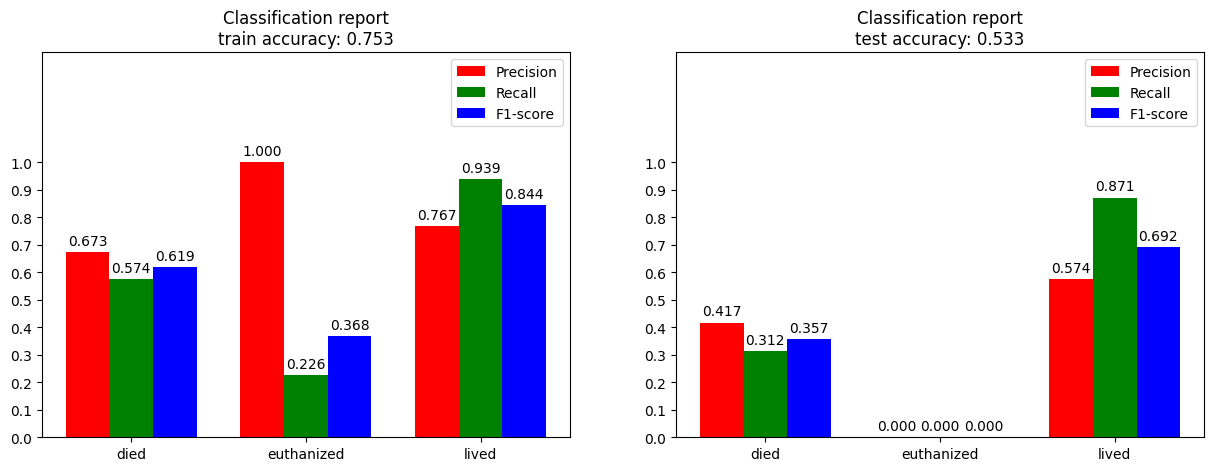

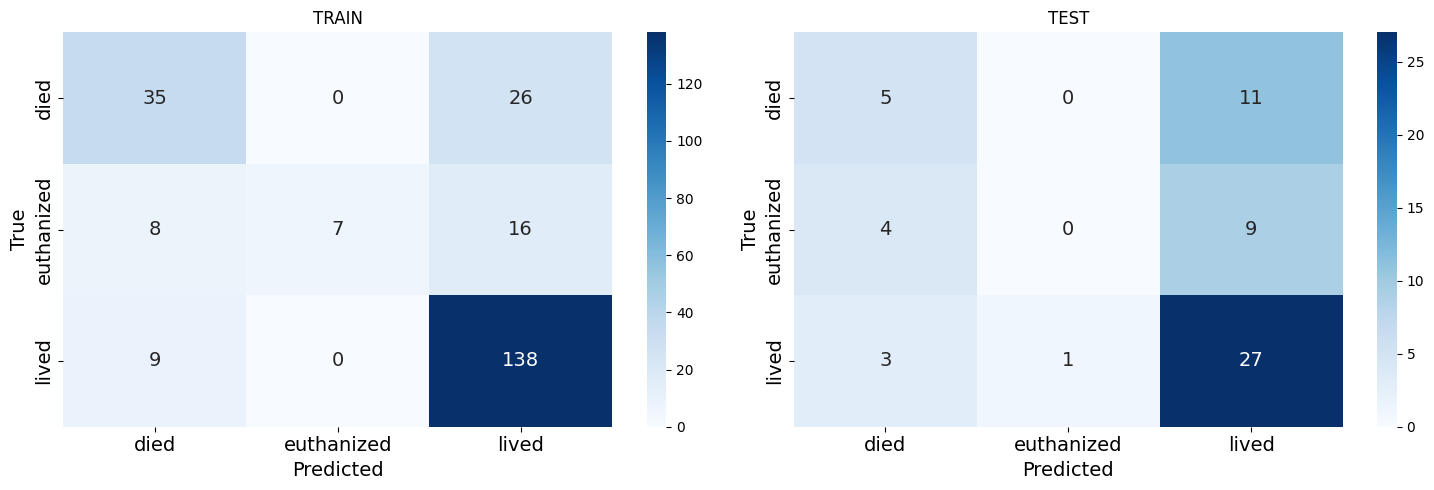

In [43]:
evaluate_model(y_train, best_estimator.predict(X_train), y_test, best_estimator.predict(X_test))

Again, nothing to be proud of...

# Neural network

In [35]:
# Here we do need to scale
mm_scaler = MinMaxScaler()
Xy = pd.concat([pd.DataFrame(mm_scaler.fit_transform(df_num), columns=df_num.columns), df_cat], axis=1)

# Split dataset into independent variables (X) and target variable (y).
#Xy = df[feature_list]
X = Xy.drop(['outcome'], axis=1)
y = Xy['outcome']

X = pd.get_dummies(X)

# Randomly generate train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

Here I experimented manually a little more.
- I varied the number of hidden layer to values somewhat in the order of magnitude of the number of features (dummies included).
- I noticed that more than two hidden layers is not useful (even detrimental).
- Very small changes in alpha and initial learning rate can have large consequences.
- Changing activation functions does not make an appreciable difference.

I could hardly make the grid search so fine-grained, so I kept the numbers around what I found should be ideal.

In [36]:
mlp = MLPClassifier(hidden_layer_sizes=(40,40), alpha=0.00009, activation='relu', solver='adam', learning_rate_init= 0.021, max_iter=5000, random_state=0)
mlp.fit(X_train,y_train)

MLPClassifier(alpha=9e-05, hidden_layer_sizes=(40, 40),
              learning_rate_init=0.021, max_iter=5000, random_state=0)

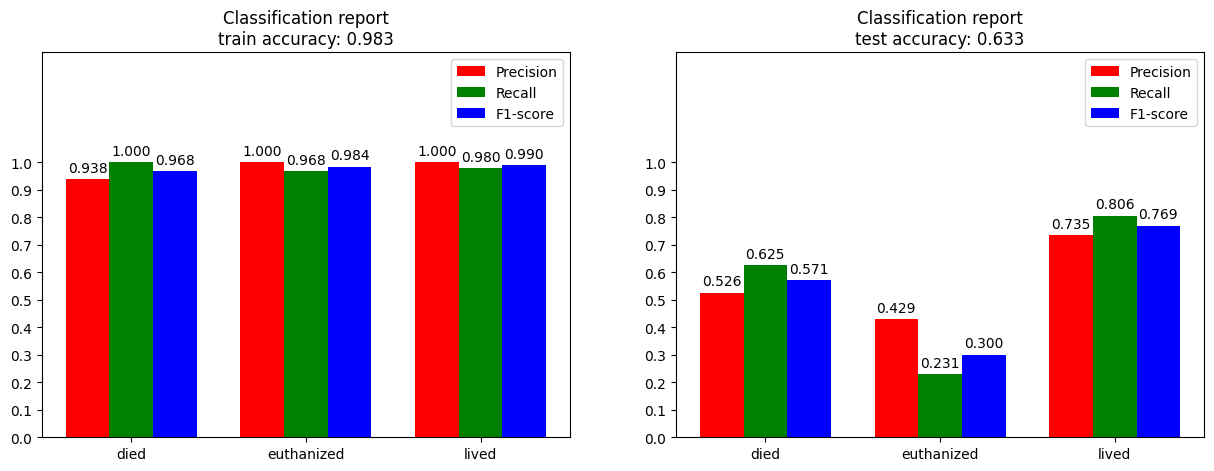

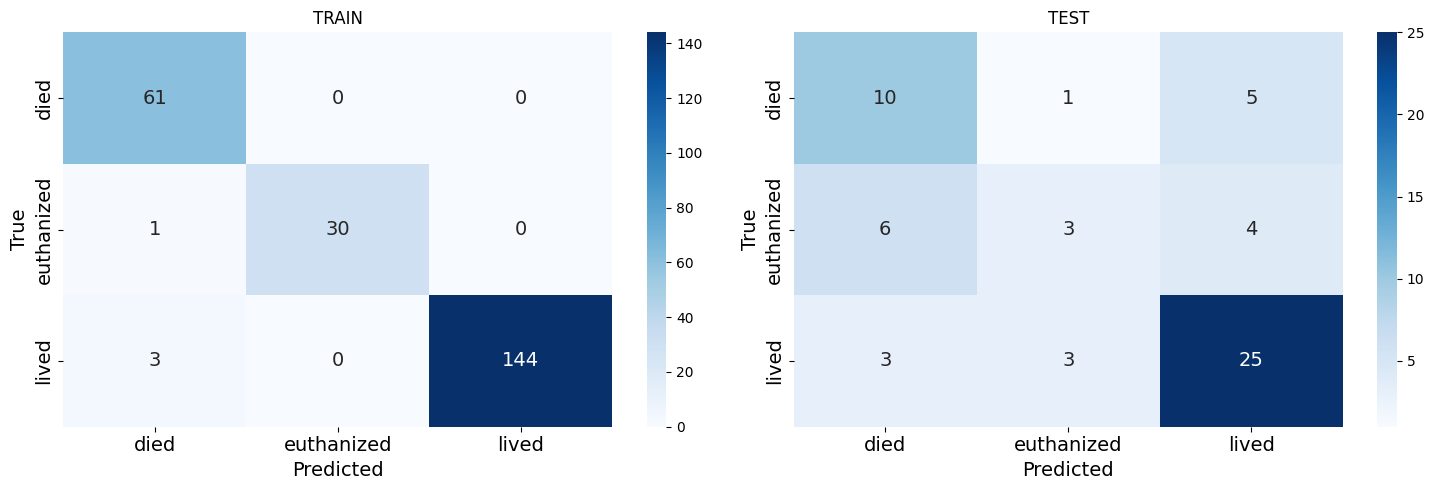

In [37]:
evaluate_model(y_train, mlp.predict(X_train), y_test, mlp.predict(X_test))

In [44]:
mlp_clf = MLPClassifier(activation='relu', solver='adam', max_iter=5000)

# Define a grid of hyperparameters
params = [{
    'hidden_layer_sizes': [(20,20),(30,30),(40,40),(50,50)],
    'alpha': [0.00005, 0.0001, 0.0002],
    'learning_rate_init': [0.01, 0.02, 0.03]
          }]

# Generate a GridSearchCV instance
mlp_clf_GS = GridSearchCV(mlp_clf,
                      param_grid=params,
                      scoring='f1_weighted',
                      cv=5)
mlp_clf_GS.fit(X_train, y_train)


# Select the best combination of hyperparameters
best_estimator = mlp_clf_GS.best_estimator_
print('The best performing combination of hyperparameters is:\n ', mlp_clf_GS.best_params_)

The best performing combination of hyperparameters is:
  {'alpha': 0.0001, 'hidden_layer_sizes': (20, 20), 'learning_rate_init': 0.01}


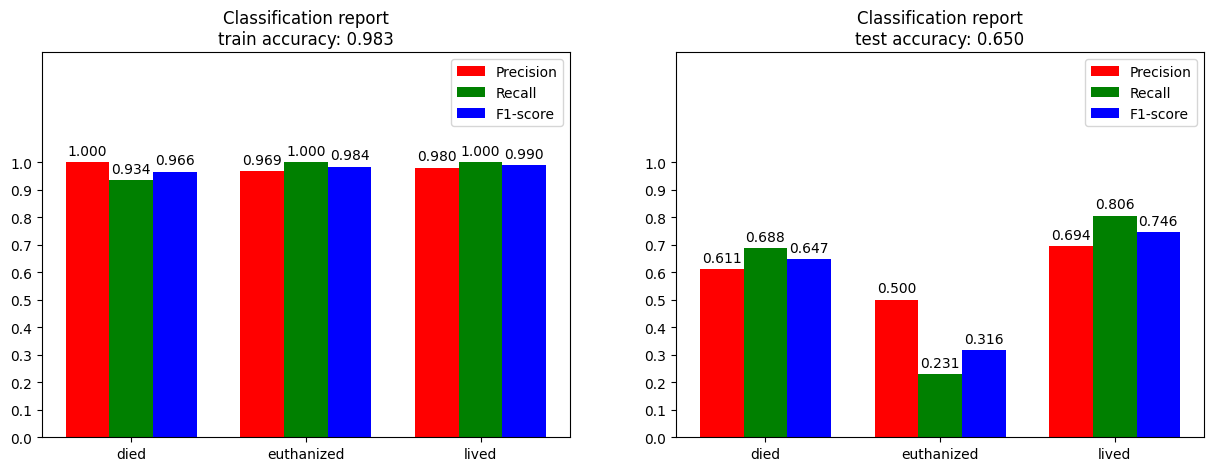

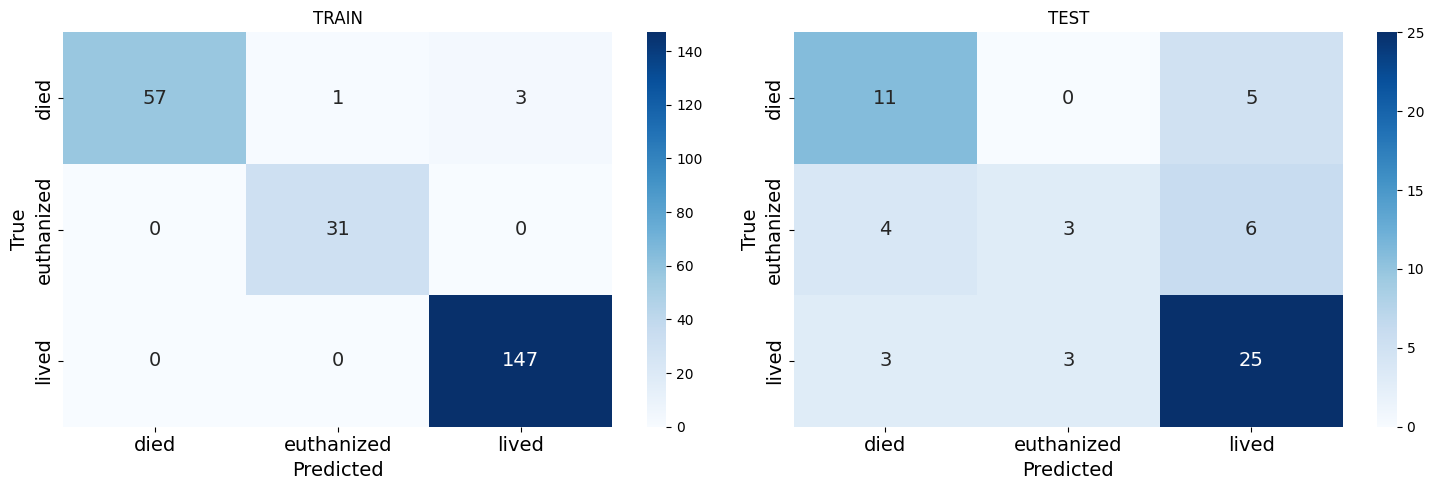

In [45]:
evaluate_model(y_train, best_estimator.predict(X_train), y_test, best_estimator.predict(X_test))

Same story as before: a great deal of overfitting. Unless you care most about predicting as many horses that will survive as possible, then this model could work for you! Reducing the number neurons does not seem to help, and we are already introducing regularization through the alpha parameter. Since it is also a completely black box I would steer clear from a neural network here.

# Conclusion

My conclusion after doing this analysis is that for this particular dataset it seems to be quite hard to avoid overfitting, even despite taking appropriate measures. I did not explicitly show it in the notebook but I tried to make the test set larger (than the 20% I used now) but that did not help either. Also other best practices such as imputation on train and test set separately, and using stratification when generating the train and test set, are proving to be counterproductive, which is somewhat frustrating.
Furthermore, it turns out that it pays off to start simple, because the humble decision tree returned the best result of all the models I tried. In order to really pinpoint the best model with its specific hyperparameters, more context is needed on what the model is going be used for (-> from which we would choose the most suitable evaluation metric).